In [53]:
import os


import warnings
from warnings import simplefilter
os.getcwd()


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# simplefilter(action='ignore', category=SettingWithCopyWarning)

def check_complete_index(df, freq='H'):
    # Create a complete datetime index
    complete_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Check if the datetime index of df has any missing timestamps
    missing_timestamps = complete_index.difference(df.index)

    if missing_timestamps.empty:
        print("There are no missing timestamps in the datetime index.")
    else:
        print(f"There are {len(missing_timestamps)} missing timestamps in the datetime index.")

In [54]:
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from h2o.automl import H2OAutoML

def preprocess(df, index_col):
    df.columns = df.columns.str.lower()
    df['date_time'] = df['date_time'].dt.tz_localize(None)
    df = df.set_index(index_col.lower())
    return df

In [55]:
random_seed = 17
max_automl_models = 5
train_fraction = 2/3

In [56]:
# NOTE: always specify parse_dates with a list
price_dm = pd.read_csv('data/price_dm.csv', parse_dates=['Date_Time'])
seps = pd.read_csv('data/seps.csv', parse_dates=['Date_Time'])
soda = pd.read_csv('data/soda.csv', parse_dates=['Date_Time'])

price_dm = preprocess(price_dm, 'date_time')
seps = preprocess(seps, 'date_time')
soda = preprocess(soda, 'date_time')

In [57]:
soda = soda.drop(columns=['date', 'longitude', 'latitude'])
price_dm = price_dm.drop(columns=['price_dm_forecast', 'price_si', 'price_si_formula'])

In [58]:
price_dm = price_dm.resample('H').mean()
soda = soda.resample('H').mean()

In [59]:
# Inner join three pandas dataframes price_dm, seps, and soda on index
all_data = price_dm.join(seps, how='inner').join(soda, how='inner')
all_data.describe().T[['mean', 'std', 'min', 'max']].round(2)

,mean,std,min,max
da_prob_catboost,0.63,0.14,0.10,0.97
da_prob_glmnet,0.61,0.10,0.19,0.93
da_prob_gp,0.61,0.12,0.19,0.91
da_prob_lgbm,0.64,0.15,0.06,0.98
da_prob_svm,0.62,0.14,0.08,0.95
da_prob_xgb,0.62,0.15,0.06,0.98
price_dm,234.62,139.12,-10.00,900.23
da_prob_truth,0.62,0.34,0.00,1.00
da_prob_median_ensemble,0.63,0.12,0.14,0.93
da_prob_mean_ensemble,0.62,0.12,0.14,0.92


In [60]:
chosen_features = [
    'price_dm', 
    'da_prob_truth',
    'da_prob_median_ensemble', 
    # 'probability', 
    'load_pred',
    'prod_pred',
    'temperature', 
    'relative_humidity',
    'pressure',
    'wind_speed',
    'rainfall',
    'snowfall',
    'snow_depth',
    # 'precip',
    'short_wave_irradiation',
]

feature_data = all_data[chosen_features].copy()

In [61]:
feature_data.columns

Index(['price_dm', 'da_prob_truth', 'da_prob_median_ensemble', 'load_pred',
       'prod_pred', 'temperature', 'relative_humidity', 'pressure',
       'wind_speed', 'rainfall', 'snowfall', 'snow_depth',
       'short_wave_irradiation'],
      dtype='object')

In [62]:
missing_values = feature_data.isna().sum()
missing_values[missing_values > 0]

price_dm                   72
da_prob_truth              72
da_prob_median_ensemble    72
dtype: int64

In [63]:
feature_data = feature_data.dropna()

In [64]:
feature_data_days = feature_data.resample('D').agg(['median', 'std'])

In [65]:

n_days = len(feature_data_days)
train_split_id = int(n_days * train_fraction)
train_split_date = feature_data_days.index[train_split_id]
train_split_date

Timestamp('2022-11-12 00:00:00', freq='D')

In [66]:
lagged_target_days = feature_data_days['price_dm'].shift(1)
lagged_target_days.columns = [f'{col}_lag1' for col in lagged_target_days.columns]
lagged_target_days

,median_lag1,std_lag1
date_time,,
2021-12-31,NaN,NaN
2022-01-01,50.050,NaN
2022-01-02,84.630,36.514912
2022-01-03,50.780,20.138148
2022-01-04,108.770,45.672087
...,...,...
2023-04-14,127.205,28.550127
2023-04-15,123.925,19.206277
2023-04-16,104.995,14.808528


In [67]:
lagged_target_hrs = lagged_target_days.resample('H').ffill()
lagged_target_hrs.tail(1) # this needs to be ffilled to the rest of the day

,median_lag1,std_lag1
date_time,,
2023-04-18,109.58,20.840144


In [68]:
combined_data = pd.concat([feature_data, lagged_target_hrs], axis=1)
combined_data[lagged_target_hrs.columns] = combined_data[lagged_target_hrs.columns].ffill()

In [69]:
feature_data = combined_data.dropna()
feature_data

,price_dm,da_prob_truth,da_prob_median_ensemble,load_pred,prod_pred,temperature,relative_humidity,pressure,wind_speed,rainfall,snowfall,snow_depth,short_wave_irradiation,median_lag1,std_lag1
date_time,,,,,,,,,,,,,,,
2022-01-02 00:00:00,52.59,0.75,0.209195,2570.0,3256.0,2.9675,99.252500,963.1050,1.2160,0.000000,0.0,0.022707,0.00000,84.63,36.514912
2022-01-02 01:00:00,48.97,0.75,0.272368,2510.0,3252.1,3.1575,99.217500,962.7450,1.2660,0.000000,0.0,0.021917,0.00000,84.63,36.514912
2022-01-02 02:00:00,34.94,0.25,0.237694,2510.0,3263.2,3.3475,99.185000,962.3850,1.3310,0.000000,0.0,0.021128,0.00000,84.63,36.514912
2022-01-02 03:00:00,29.56,0.00,0.192521,2540.0,3265.2,3.2375,99.115000,961.9850,1.1635,0.000000,0.0,0.020438,0.00000,84.63,36.514912
2022-01-02 04:00:00,33.97,0.50,0.198483,2580.0,3274.1,2.9500,99.017500,961.5650,0.9510,0.000000,0.0,0.019810,0.00000,84.63,36.514912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-18 17:00:00,130.46,0.50,0.562612,3220.0,2798.5,9.8550,64.225000,955.7850,1.4885,0.005712,0.0,0.000000,2.40925,109.58,20.840144
2023-04-18 18:00:00,135.24,0.00,0.556763,3140.0,2756.7,8.7900,68.625000,955.9525,1.5910,0.002856,0.0,0.000000,0.00000,109.58,20.840144
2023-04-18 19:00:00,122.42,0.50,0.500613,3000.0,2711.0,8.1500,71.285000,956.0500,1.6835,0.000357,0.0,0.000000,0.00000,109.58,20.840144


In [70]:
train = feature_data[feature_data.index < train_split_date]
test = feature_data[feature_data.index >= train_split_date]

In [71]:
correlation_matrix = train.corr()
target_correlations = correlation_matrix['price_dm']

In [72]:
target_correlations.to_frame()

,price_dm
price_dm,1.000000
da_prob_truth,-0.071369
da_prob_median_ensemble,0.060671
load_pred,-0.005233
prod_pred,-0.199505
temperature,0.409012
relative_humidity,-0.160288
pressure,-0.049876
wind_speed,0.014622
rainfall,0.016231


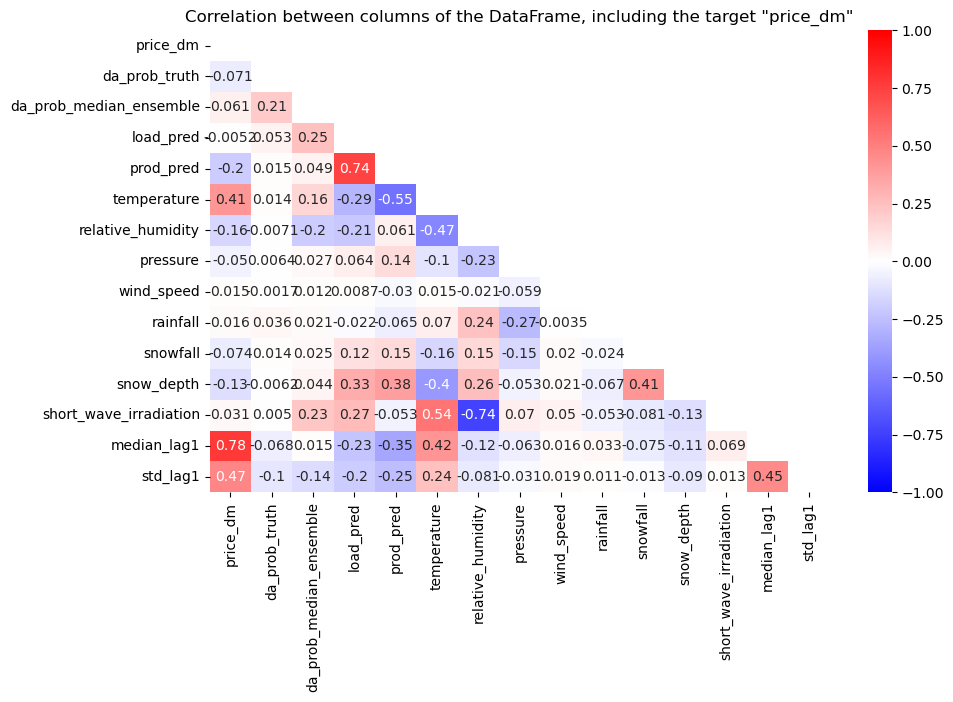

In [73]:
plt.figure(figsize=(10, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create a mask to show only the lower triangle
sns.heatmap(correlation_matrix, annot=True, vmin=-1, cmap='bwr', vmax=1, mask=mask)
plt.title('Correlation between columns of the DataFrame, including the target "price_dm"')
plt.show()


### Observations
- higher temperature -> higher price_dm
- lower prod_pred -> higher price_dm
- low pressure -> rain
- high load_pred -> high prod_pred

In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot layout with two rows and one column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)



# Add a line plot for price_dm in the second row
fig.add_trace(go.Scatter(x=all_data.index, y=all_data['price_dm'],
                         mode='lines', name='Price DM',
                         line=dict(color='green')), row=1, col=1)

# Add a line plot for temperature in the first row
fig.add_trace(go.Scatter(x=all_data.index, y=all_data['load_pred'],
                         mode='lines', name='Load pred',
                         line=dict(color='blue')), row=2, col=1)

# Add a line plot for temperature in the first row
fig.add_trace(go.Scatter(x=all_data.index, y=all_data['temperature'],
                         mode='lines', name='Temperature',
                         line=dict(color='red')), row=3, col=1)



# Set the x-axis title
fig.update_xaxes(title_text='Time', row=3, col=1)

# Set the y-axis title for the second row (price_dm)
fig.update_yaxes(title_text='Price DM', row=1, col=1, showgrid=False)

# Set the y-axis title for the second row (price_dm)
fig.update_yaxes(title_text='load_pred', row=2, col=1, showgrid=False)

# Set the y-axis title for the first row (temperature)
fig.update_yaxes(title_text='Temperature', row=3, col=1, showgrid=False)


# Set the plot title
fig.update_layout(title='Temperature and Price DM Correlation in Time')

# Show the plot
fig.show()

In [75]:
train

,price_dm,da_prob_truth,da_prob_median_ensemble,load_pred,prod_pred,temperature,relative_humidity,pressure,wind_speed,rainfall,snowfall,snow_depth,short_wave_irradiation,median_lag1,std_lag1
date_time,,,,,,,,,,,,,,,
2022-01-02 00:00:00,52.59,0.75,0.209195,2570.0,3256.0,2.9675,99.2525,963.1050,1.2160,0.0,0.0,0.022707,0.0,84.63,36.514912
2022-01-02 01:00:00,48.97,0.75,0.272368,2510.0,3252.1,3.1575,99.2175,962.7450,1.2660,0.0,0.0,0.021917,0.0,84.63,36.514912
2022-01-02 02:00:00,34.94,0.25,0.237694,2510.0,3263.2,3.3475,99.1850,962.3850,1.3310,0.0,0.0,0.021128,0.0,84.63,36.514912
2022-01-02 03:00:00,29.56,0.00,0.192521,2540.0,3265.2,3.2375,99.1150,961.9850,1.1635,0.0,0.0,0.020438,0.0,84.63,36.514912
2022-01-02 04:00:00,33.97,0.50,0.198483,2580.0,3274.1,2.9500,99.0175,961.5650,0.9510,0.0,0.0,0.019810,0.0,84.63,36.514912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11 19:00:00,222.37,0.50,0.499431,3220.0,2780.8,6.0650,82.0825,969.8325,1.5035,0.0,0.0,0.000000,0.0,256.09,69.305958
2022-11-11 20:00:00,210.50,0.75,0.523877,2900.0,2716.1,6.0250,80.7875,969.8150,1.5460,0.0,0.0,0.000000,0.0,256.09,69.305958
2022-11-11 21:00:00,195.41,0.75,0.590905,2760.0,2686.2,6.0700,78.7350,969.5925,1.5860,0.0,0.0,0.000000,0.0,256.09,69.305958


In [76]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,32 mins 02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,5 months and 24 days !!!
H2O_cluster_name:,H2O_from_python_m_kowiq8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.799 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [77]:
train['da_prob_truth'] = (train['da_prob_truth'] * 100).astype(int)
test['da_prob_truth'] = (test['da_prob_truth'] * 100).astype(int)

/tmp/ipykernel_91559/670481967.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_91559/670481967.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
# Convert the Pandas DataFrame (feature_data) into an H2O DataFrame
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

train_h2o['da_prob_truth'] = train_h2o['da_prob_truth'].asfactor()
test_h2o['da_prob_truth'] = test_h2o['da_prob_truth'].asfactor()

x = train_h2o.columns
y = "price_dm"
x.remove(y)

print(train_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  price_dm    da_prob_truth    da_prob_median_ensemble    load_pred    prod_pred    temperature    relative_humidity    pressure    wind_speed    rainfall    snowfall    snow_depth    short_wave_irradiation    median_lag1    std_lag1
     52.59               75                   0.209195         2570       3256           2.9675              99.2525     963.105        1.216            0           0     0.0227075                  0                 84.63     36.5149
     48.97               75                   0.272368         2510       3252.1         3.1575              99.2175     962.745        1.266            0           0     0.0219175                  0                 84.63     36.5149
     34.94               25                   0.237694         2510       3263.2         3.3475             

In [79]:
algos = [
    'GLM', 
    # 'DRF', 
    'XGBoost',
    'GBM',
    # 'StackedEnsemble'
    # 'DeepLearning'
]

aml = H2OAutoML(
    max_models=max_automl_models, 
    seed=random_seed,
    include_algos=algos,
    nfolds=0
    )

aml.train(x=x, y=y, training_frame=train_h2o)

# # View the AutoML Leaderboard
# lb = aml.leaderboard
# lb.head(rows=lb.nrows)

# h2o.cluster().shutdown(prompt=False)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,260.0,260.0,183103.0,7.0,7.0,7.0,14.0,110.0,51.28846
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2023-04-20 18:30:07,0.006 sec,0.0,143.1084519,111.6424552,20480.0290077,149.6471367,116.3389893,22394.2655373
,2023-04-20 18:30:07,0.030 sec,5.0,98.9922068,76.9564026,9799.4570067,103.7828184,80.8874848,10770.8733938
,2023-04-20 18:30:07,0.054 sec,10.0,74.6750704,57.8206206,5576.3661426,80.4798290,62.1348594,6477.0028708
,2023-04-20 18:30:07,0.077 sec,15.0,59.5598237,46.1551799,3547.3726013,66.7911577,51.1901288,4461.0587467
,2023-04-20 18:30:07,0.099 sec,20.0,50.8027893,39.0503517,2580.9233985,58.9740502,44.5186972,3477.9385926
,2023-04-20 18:30:07,0.120 sec,25.0,44.8722988,34.2957013,2013.5231994,53.8434832,40.2957457,2899.1206868
,2023-04-20 18:30:07,0.141 sec,30.0,40.9822771,31.0882874,1679.5470342,50.8231168,37.6959701,2582.9892028
,2023-04-20 18:30:07,0.166 sec,35.0,38.4430812,28.9719667,1477.8704944,48.8460924,36.0454864,2385.9407439


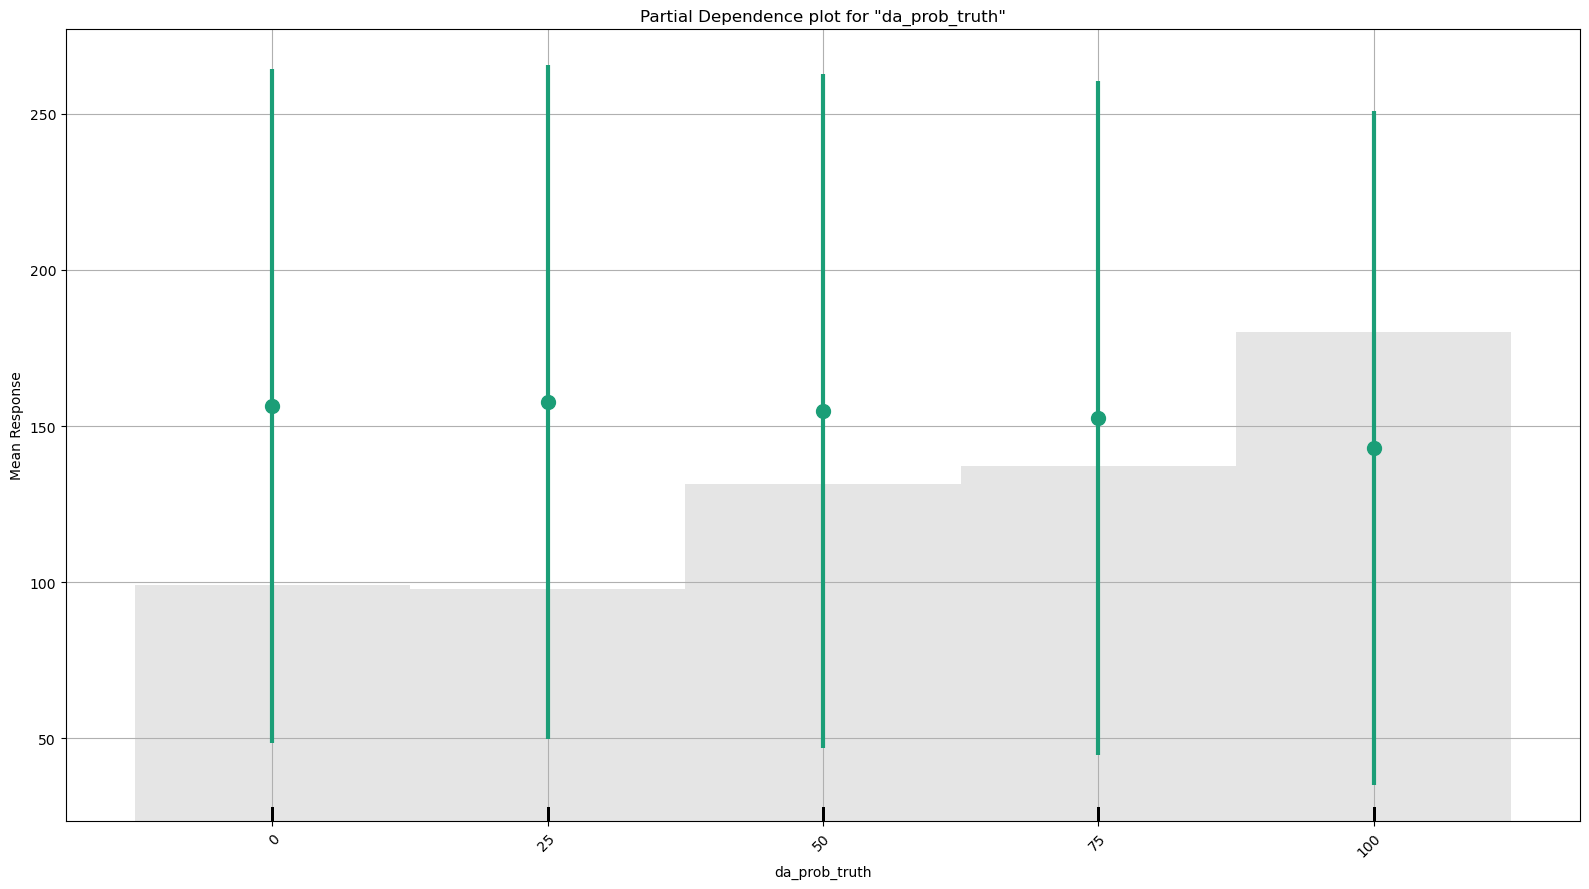

In [80]:
glm = aml.get_best_model(algorithm = "GLM", criterion = "RMSE")

# glm.pd_plot(test_h2o, "temperature")
glm.pd_plot(test_h2o, "da_prob_truth")

In [81]:
# save the model
# model_path = h2o.save_model(model=aml.leader, path="/home/m/repo/ThinkBayes2/mine/model/", force=True)
# print(model_path)
# model_path_load = "model/GBM_4_AutoML_1_20230420_174208"
# model = h2o.load_model(model_path_load)

In [82]:
model = aml.get_best_model(criterion = "RMSE")

In [83]:
predictions_h2o = model.predict(test_h2o)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [84]:
pred = predictions_h2o.as_data_frame()
pred.index = test.index
pred['price_dm'] = test['price_dm']

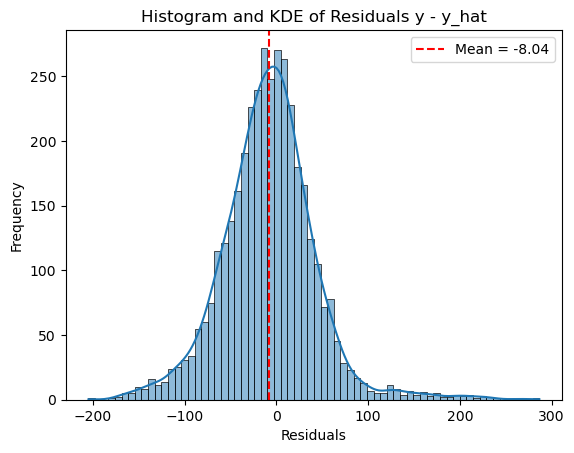

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

y_true = pred['price_dm']
y_pred = pred['predict']
residuals = y_true - y_pred

sns.histplot(residuals, kde=True)
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'Mean = {residuals.mean():.2f}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram and KDE of Residuals y - y_hat')
plt.legend()
plt.show()


In [86]:
rmse = np.sqrt(np.mean(residuals**2))
smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 51.78
SMAPE: 27.47


In [87]:
import plotly.graph_objects as go

fig = go.Figure()

# Add 'price_dm' trace
fig.add_trace(go.Scatter(x=pred.index, y=pred['price_dm'], mode='lines', name='price_dm'))

# Add 'predict' trace
fig.add_trace(go.Scatter(x=pred.index, y=pred['predict'], mode='lines', name='predict'))

# Set the title and axis labels
fig.update_layout(title='Price_dm and Predict vs Time', xaxis_title='Time', yaxis_title='Value')

# Show the plot
fig.show()

## Shapley values
- VERTICAL location - Feature importance: Variables are ranked in descending order.
- RED - high, BLUE - low value for the dataset 
- HORIZONTAL location shows whether the effect of that value caused a higher or lower prediction.

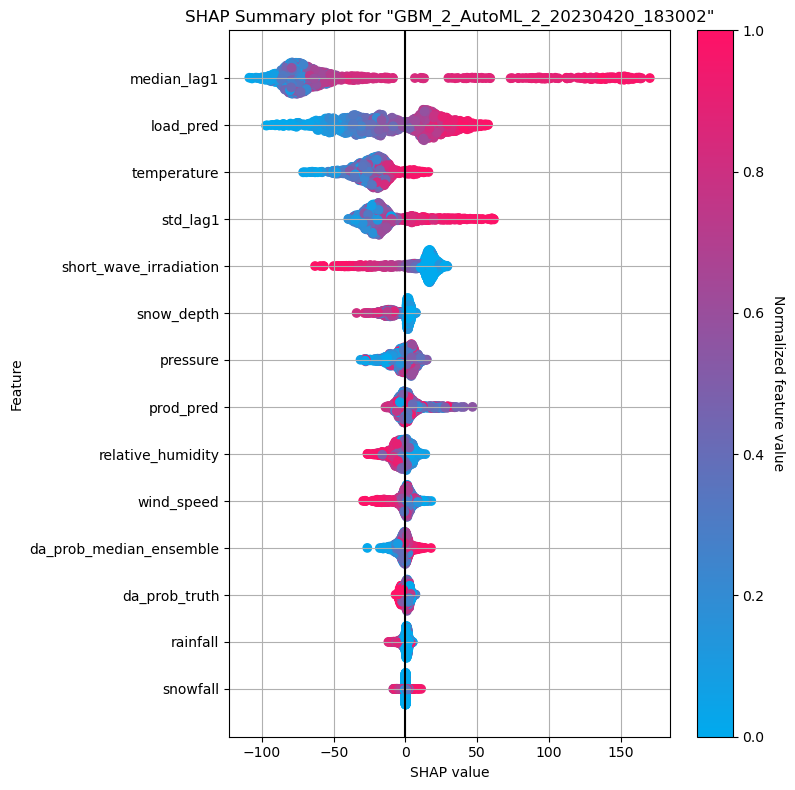

In [90]:
shap_plot = model.shap_summary_plot(test_h2o, figsize=(8, 8))
shap_plot

# Interpretation
- Higher wind_speed leads to lower electricity price. (Excess energy)
- higher variance in the previous day, higher energy price this day
- higher median in the prev day, higher median this day
- higher temperature, higher price
- higher expected probability, higher price
- more solar irradiation, lower price_dm price


In [108]:
import plotly.express as px

fig = px.histogram(train, x='wind_speed', histnorm='probability density')
fig.show()

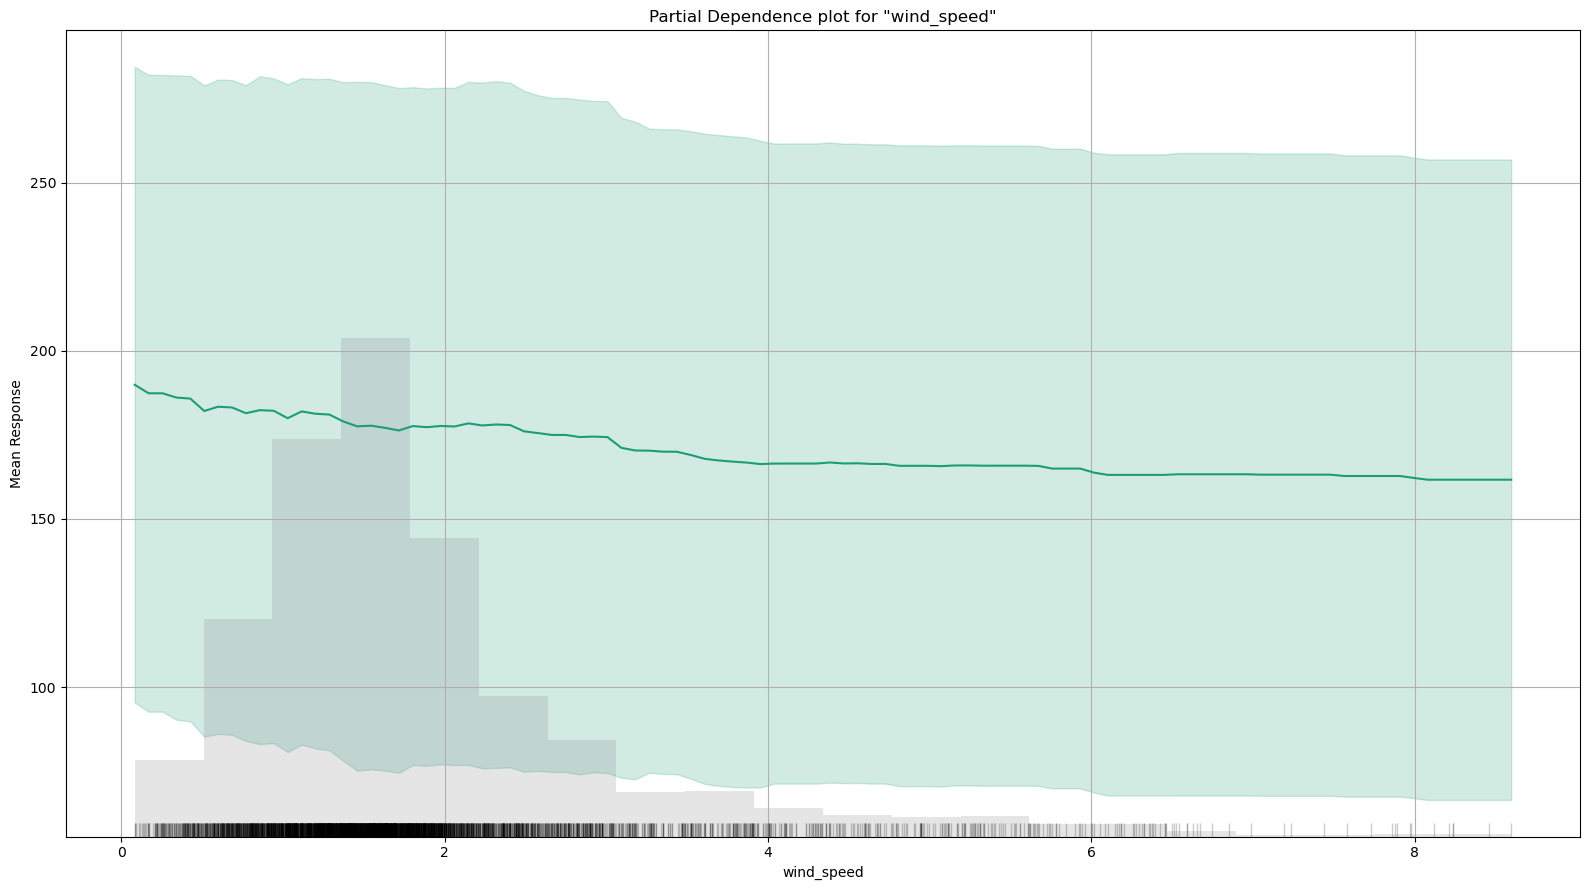

In [99]:
pd_plot = model.pd_plot(test_h2o, "wind_speed")

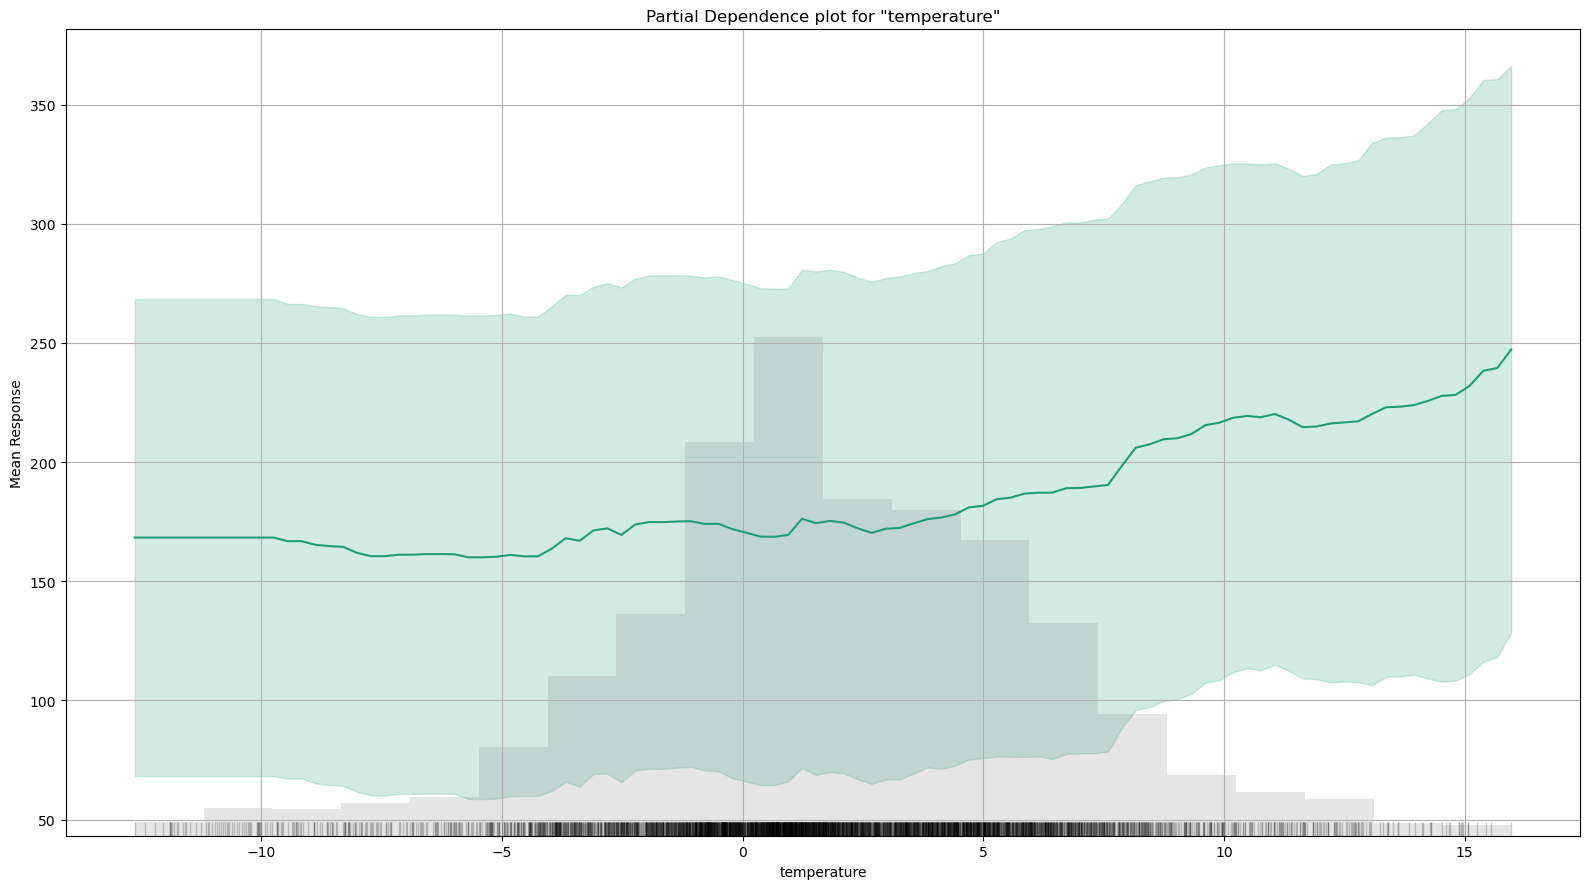

In [91]:
pd_plot = model.pd_plot(test_h2o, "temperature")

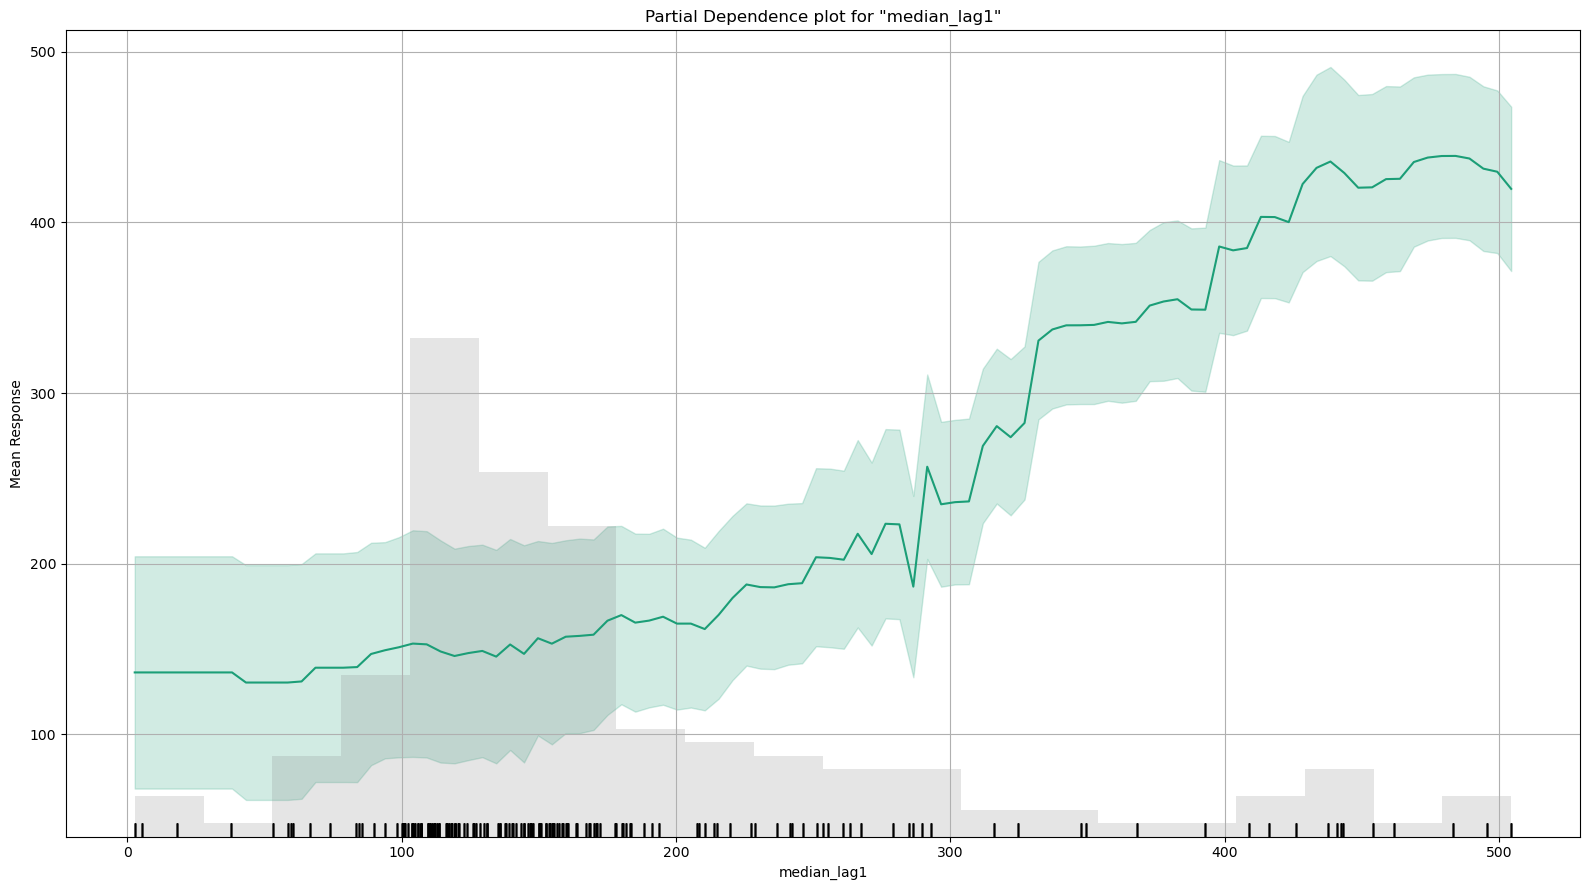

In [92]:
pd_plot = model.pd_plot(test_h2o, "median_lag1")

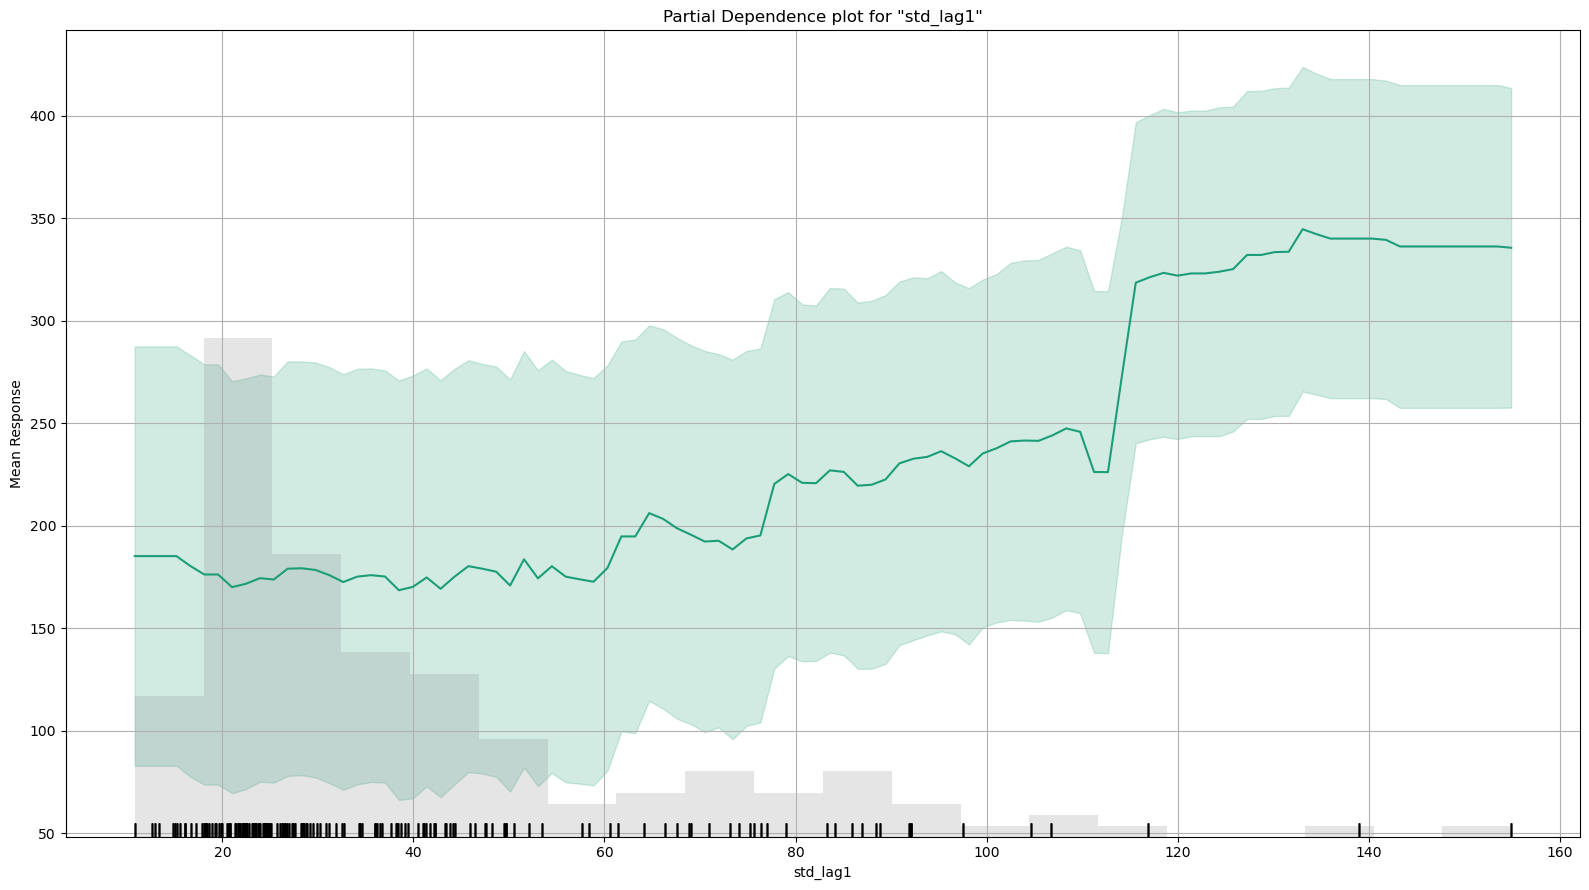

In [93]:
pd_plot = model.pd_plot(test_h2o, "std_lag1")

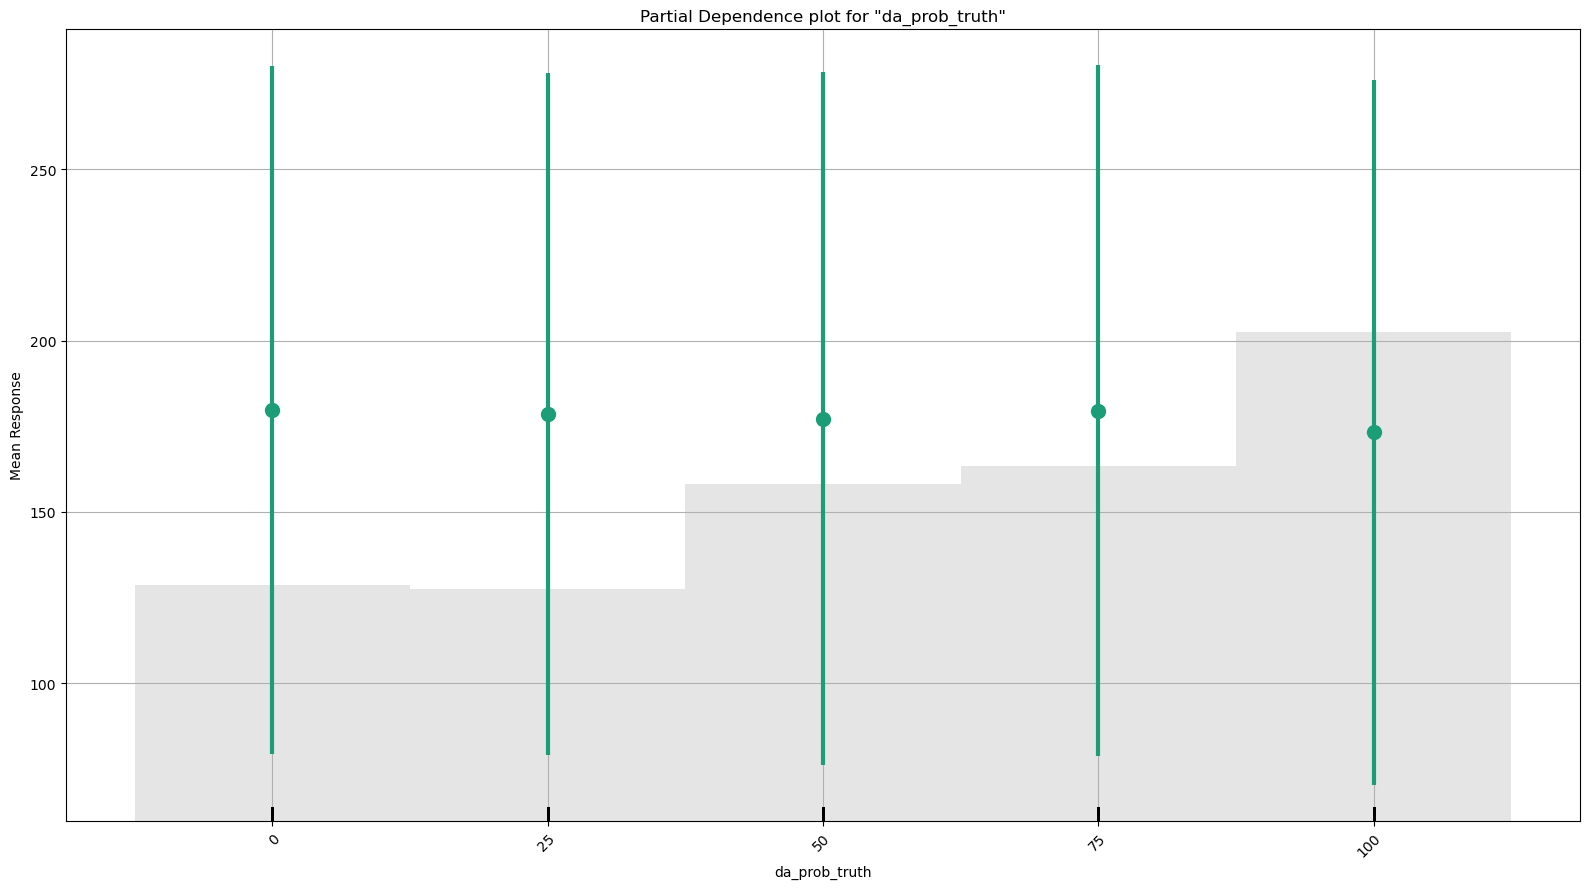

In [94]:
pd_plot = model.pd_plot(test_h2o, "da_prob_truth")